In [ ]:
# !pip install python-igraph
# !pip install cairocffi

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     |████████████████████████████████| 7.9 MB 4.6 MB/s 
     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 145 kB 4.9 MB/s 
     |████████████████████████████████| 112 kB 17.6 MB/s 
     |████████████████████████████████| 74 kB 2.4 MB/s 
     |████████████████████████████████| 596 kB 39.1 MB/s 


In [ ]:
# # -*- coding: utf-8 -*-
# """Dataset-Preparation.ipynb

# Automatically generated by Colaboratory.

# Original file is located at
#     https://colab.research.google.com/drive/12VZ0DXvkD7smWXkWQYl89AYhN0XIj95H
# """

# # !pip install python-igraph
# # !pip install cairocffi



# # !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# # !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# # !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# # !pip install pysam

# # pip3 install torch==1.9.0 torchvision==0.10.0
# # conda install -c bioconda pysam

# # pip3 uninstall torch torch-scatter torch-sparse torch-geometric

# # pip3 install torch --no-cache-dir
# # pip3 install torch-scatter --no-cache-dir -f https://data.pyg.org/whl/torch-1.10.0+cu102.html
# # pip3 install torch-sparse --no-cache-dir -f https://data.pyg.org/whl/torch-1.10.0+cu102.html
# # pip3 install torch-geometric --no-cache-dir

# # from google.colab import drive
# # drive.mount('/content/gdrive')

# # gnndatasetpath = "/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Test_Datasets"
# gnndatasetpath = "/home/hp/FYP/GNN/gnn-datasets/Test_Datasets"

# _DEBUG = True

# # Commented out IPython magic to ensure Python compatibility.
# import re
# # from igraph import *
# from collections import defaultdict
# import os
# import random

# # %matplotlib inline
# import torch
# import networkx as nx
# import matplotlib.pyplot as plt
# from torch_geometric.data import Data
# from torch_geometric.utils import to_networkx
# from torch_geometric.nn import GCNConv
# import torch.nn.functional as F

# from pysam import FastaFile

# ## Functions

# def visualize_graph(G, color):
#     plt.figure(figsize=(7,7))
#     plt.xticks([])
#     plt.yticks([])
#     nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
#                      node_color=color, cmap="Set2")
#     plt.show()


# def visualize_embedding(h, color, epoch=None, loss=None):
#     plt.figure(figsize=(7,7))
#     plt.xticks([])
#     plt.yticks([])
#     h = h.detach().cpu().numpy()
#     plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
#     if epoch is not None and loss is not None:
#         plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
#     plt.show()

# # TODO: Update the function with the library
# def predict(sequence):
#   return [random.uniform(0, 1), random.uniform(0, 1)]

# # TODO: Update the function with the library
# def get_label_sequences(fastafile):
#   start = 'NODE_'
#   end = '_length_'
#   features = {}
  
#   fasta_object = FastaFile(fastafile)
#   fasta_references = fasta_object.references

#   for name in fasta_references:
#     attributes = {}

#     contig_num = int(str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1))
#     predicted_values = predict(fasta_object.fetch(reference = name))

#     attributes["features"] = predicted_values
#     attributes["class"] = 0.5
#     attributes["train_sem"] = False

#     # TODO Change this
#     color_value = sum(predicted_values) / len(predicted_values)

#     if color_value < 0.4:
#       attributes["class"] = 0
#       attributes["train_sem"] = True
#     elif color_value > 0.8:
#       attributes["class"] = 1
#       attributes["train_sem"] = True

#     features[contig_num] = attributes
#   return features

# def get_the_segment_contig_map(contigfilepath):
#   paths = {}
#   segment_contigs = {}
#   node_count = 0

#   with open(contigfilepath) as file:
#     name = file.readline()
#     path = file.readline()
    
#     while name != "" and path != "":
            
#         while ";" in path:
#             path = path[:-2]+","+file.readline()
        
#         start = 'NODE_'
#         end = '_length_'
#         contig_num = int(str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1))
        
#         segments = path.rstrip().split(",")
        
#         if contig_num not in paths:
#             node_count += 1
#             paths[contig_num] = [segments[0], segments[-1]]
        
#         for segment in segments:
#             # TODO Check this
#             if segment.endswith("+") or segment.endswith("-"):
#                 segment = segment[:-1]
#             if segment not in segment_contigs:
#                 segment_contigs[segment] = set([contig_num])
#             else:
#                 segment_contigs[segment].add(contig_num)
        
#         name = file.readline()
#         path = file.readline()

#     return segment_contigs, paths, node_count

# def adjust_weights(weight_list):
#   summation = 0
#   count = 0
#   none_indexes = []
#   for i in range(len(weight_list)):
#     if weight_list[i] == None:
#       none_indexes.append(i)
#       continue
#     count += 1
#     summation += weight_list[i]
  
#   average_weight = summation / count
#   for i in none_indexes:
#     weight_list[i] = average_weight

#   return weight_list

# #make segment_contigs global
# def generate_edge_tensor(gfafilepath, segment_contigs):
#   source_list = []
#   destination_list= []
#   weight_list = []
#   isNeedToAdjustWeights = False

#   with open(gfafilepath) as file:
#     line = file.readline()
#     while line != "":
#       # Identify lines with link information
#       if "L" in line:
#           strings = line.split("\t")
#           seg1, seg2 = strings[1], strings[3]
#           weight = strings[5].strip()
#           contig1 = segment_contigs[seg1]
#           contig2 = segment_contigs[seg2]
#           for cont1 in contig1:
#             for cont2 in contig2:
#               source_list.append(cont1)
#               destination_list.append(cont2)
#               if weight.isnumeric():
#                 weight_list.append(int(weight))
#               elif weight[:-1].isnumeric():
#                 weight_list.append(int(weight[:-1]))
#               else:
#                 weight_list.append(None)
#                 isNeedToAdjustWeights = True
#       line = file.readline()
#     if isNeedToAdjustWeights:
#       weight_list = adjust_weights(weight_list)
#     return source_list, destination_list, weight_list

# def generate_tensors(features, source_list, destination_list, weight_list, node_count):
#   feature_list = []
#   catergory_list = []
#   train_data = []
#   for i in range(node_count):
#     node_features_dict = features[i]
#     catergory_list.append(node_features_dict["class"])
#     train_data.append(node_features_dict["train_sem"])
#     feature_list.append(node_features_dict["features"])
  
#   node_features = torch.DoubleTensor(feature_list).unsqueeze(1)
#   y = torch.LongTensor(catergory_list)
#   print(source_list)
#   print(destination_list)
#   print(feature_list)
#   edge_index = torch.tensor([source_list, destination_list], dtype=torch.long)
#   edge_attr = torch.DoubleTensor(weight_list)

#   data = Data(x = node_features, edge_index = edge_index, y = y, edge_attr = edge_attr)
#   return data



# def generate_data(gfafilepath, contigfilepath, fastafilepath):
#   features = get_label_sequences(fastafilepath)
#   segment_contigs, paths, node_count = get_the_segment_contig_map(contigfilepath)
#   source_list, destination_list, weight_list = generate_edge_tensor(gfafilepath, segment_contigs)
#   data = generate_tensors(features, source_list, destination_list, weight_list, node_count)
#   return data

# ### Graph Neural Network Task

# class GCN(torch.nn.Module):
#     def __init__(self, inputfeatures = 2, hidden_channels = 2, num_classes = 2):
#         super().__init__()
#         torch.manual_seed(1234567)
#         self.conv1 = GCNConv(inputfeatures, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, num_classes)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x

# def train():
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(data.x, data.edge_index)  # Perform a single forward pass.
#       loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss

# def test():
#       model.eval()
#       out = model(data.x, data.edge_index)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
#       test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
#       return test_acc

# def iterate():
#   for epoch in range(1, 101):
#       loss = train()
#       print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# def process():
#   directory = gnndatasetpath
#   data = None
#   for datafolder in os.listdir(directory):
#       dataset = os.path.join(directory, datafolder)
#       gfafilepath = str(dataset) + "/assembly_graph_with_scaffolds.gfa"
#       contigfilepath = str(dataset) + "/contigs.paths"
#       fastafilepath = str(dataset) + "/contigs.fasta"

#       data = generate_data(gfafilepath, contigfilepath, fastafilepath)

#       G = to_networkx(data, to_undirected=True)
#       visualize_graph(G, color=data.y)

#       if _DEBUG:
#         return data
#         break

# data = process()

# # from IPython.display import Javascript  # Restrict height of output cell.
# # display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# model = GCN(hidden_channels=16)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = torch.nn.CrossEntropyLoss()


# model = GCN(inputfeatures = 2, hidden_channels = 2, num_classes = 2)
# print(model)

# eval_results = model.eval()
# print(eval_results)

# # print("x:- ", len(data.x))
# # data.edge_index

# # out = model(data.x, data.edge_index)
# # visualize(out, color=data.y)

# # iterate()

# # # TODO: Update the function with the library
# # def get_label_sequences(fastafile):
# #   start = 'NODE_'
# #   end = '_length_'
# #   features = {}
  
# #   with open(fastafile, 'r') as file:
# #     line = file.readline()
# #     while line != "":
# #       attributes = {}
# #       if line.startswith(">"):

# #         name = line.lstrip(">")
# #         contig_num = str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1)
# #         predicted_values = predict("")

# #         attributes["features"] = predicted_values
# #         attributes["class"] = 0.5
# #         attributes["train_sem"] = False

# #         # TODO Change this
# #         color_value = sum(predicted_values) / len(predicted_values)

# #         if color_value < 0.4:
# #           attributes["class"] = 0
# #           attributes["train_sem"] = True
# #         elif color_value > 0.8:
# #           attributes["class"] = 1
# #           attributes["train_sem"] = True

# #         features[contig_num] = attributes
# #         line = file.readline()

# #     return features

In [ ]:
!python --version

Python 3.7.12


In [ ]:
!python -c "import torch; print(torch.__version__)"

1.10.0+cu111


In [ ]:
!pip install pysam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
gnndatasetpath = "/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Test_Datasets"

In [ ]:
_DEBUG = True

In [ ]:
import re
# from igraph import *
from collections import defaultdict
import os
import random

%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

from pysam import FastaFile

from sklearn.manifold import TSNE


In [ ]:
## Functions

In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
# TODO: Update the function with the library
def predict(sequence):
  return [random.uniform(0, 1), random.uniform(0, 1)]

In [ ]:
# TODO: Update the function with the library
def get_label_sequences(fastafile):
  start = 'NODE_'
  end = '_length_'
  features = {}
  
  fasta_object = FastaFile(fastafile)
  fasta_references = fasta_object.references

  for name in fasta_references:
    attributes = {}

    contig_num = int(str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1))
    predicted_values = predict(fasta_object.fetch(reference = name))

    attributes["features"] = predicted_values
    attributes["class"] = 0.5
    attributes["train_sem"] = False

    # TODO Change this
    color_value = sum(predicted_values) / len(predicted_values)

    if color_value < 0.4:
      attributes["class"] = 0
      attributes["train_sem"] = True
    elif color_value > 0.8:
      attributes["class"] = 1
      attributes["train_sem"] = True

    features[contig_num] = attributes
  return features

In [ ]:

def get_the_segment_contig_map(contigfilepath):
  paths = {}
  segment_contigs = {}
  node_count = 0

  with open(contigfilepath) as file:
    name = file.readline()
    path = file.readline()
    
    while name != "" and path != "":
            
        while ";" in path:
            path = path[:-2]+","+file.readline()
        
        start = 'NODE_'
        end = '_length_'
        contig_num = int(str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1))
        
        segments = path.rstrip().split(",")
        
        if contig_num not in paths:
            node_count += 1
            paths[contig_num] = [segments[0], segments[-1]]
        
        for segment in segments:
            # TODO Check this
            if segment.endswith("+") or segment.endswith("-"):
                segment = segment[:-1]
            if segment not in segment_contigs:
                segment_contigs[segment] = set([contig_num])
            else:
                segment_contigs[segment].add(contig_num)
        
        name = file.readline()
        path = file.readline()

    return segment_contigs, paths, node_count

In [ ]:
def adjust_weights(weight_list):
  summation = 0
  count = 0
  none_indexes = []
  for i in range(len(weight_list)):
    if weight_list[i] == None:
      none_indexes.append(i)
      continue
    count += 1
    summation += weight_list[i][0]
  
  average_weight = summation / count
  for i in none_indexes:
    weight_list[i] = [average_weight]

  return weight_list

In [ ]:
#make segment_contigs global
def generate_edge_tensor(gfafilepath, segment_contigs):
  source_list = []
  destination_list= []
  weight_list = []
  isNeedToAdjustWeights = False

  with open(gfafilepath) as file:
    line = file.readline()
    while line != "":
      # Identify lines with link information
      if "L" in line:
          strings = line.split("\t")
          seg1, seg2 = strings[1], strings[3]
          weight = strings[5].strip()
          contig1 = segment_contigs[seg1]
          contig2 = segment_contigs[seg2]
          for cont1 in contig1:
            for cont2 in contig2:
              source_list.append(cont1)
              destination_list.append(cont2)
              if weight.isnumeric():
                weight_list.append([int(weight)])
              elif weight[:-1].isnumeric():
                weight_list.append([int(weight[:-1])])
              else:
                weight_list.append(None)
                isNeedToAdjustWeights = True
      line = file.readline()
    if isNeedToAdjustWeights:
      weight_list = adjust_weights(weight_list)
    return source_list, destination_list, weight_list


In [ ]:
def generate_tensors(features, source_list, destination_list, weight_list, node_count):
  feature_list = []
  catergory_list = []
  train_data = []
  for i in range(node_count):
    node_features_dict = features[i]
    catergory_list.append(node_features_dict["class"])
    train_data.append(node_features_dict["train_sem"])
    feature_list.append(node_features_dict["features"])
  
  node_features = torch.DoubleTensor(feature_list)
  # node_features = torch.DoubleTensor(feature_list).unsqueeze(1)
  y = torch.LongTensor(catergory_list)
  print("source_list", source_list[:10])
  print("destination_list", destination_list[:10])
  print("weight_list", weight_list[:10])
  print("feature_list", feature_list[:10])
  edge_index = torch.tensor([source_list, destination_list], dtype=torch.long)
  edge_attr = torch.DoubleTensor(weight_list)

  data = Data(x = node_features, edge_index = edge_index, y = y, edge_attr = edge_attr)
  return data, train_data

In [ ]:
# def generate_tensors(features, source_list, destination_list, weight_list, node_count):
#   feature_list = []
#   catergory_list = []
#   train_data = []
#   for i in range(node_count):
#     node_features_dict = features[i]
#     catergory_list.append(node_features_dict["class"])
#     train_data.append(node_features_dict["train_sem"])
#     feature_list.append(node_features_dict["features"])
#     if i == 1:
#       print("This is i = 1 :- " , node_features_dict["features"])
  
#   node_features = torch.DoubleTensor(feature_list)
#   y = torch.LongTensor(catergory_list)
#   print("source_list:- ", source_list)
#   print("destination_list:- ", destination_list)
#   print("feature_list:- ", feature_list)
#   print("weight_list:- ", weight_list)
#   edge_index = torch.tensor([source_list, destination_list], dtype=torch.long)
#   edge_attr = torch.DoubleTensor(weight_list)
#   print("node_features:- ", node_features)
#   print("edge_index:- ", edge_index.t())
#   print("edge_attr:- ", edge_attr)

#   data = Data(x = node_features, edge_index = edge_index, y = y, edge_attr = edge_attr)
#   return data

# process()

In [ ]:
def generate_data(gfafilepath, contigfilepath, fastafilepath):
  features = get_label_sequences(fastafilepath)
  segment_contigs, paths, node_count = get_the_segment_contig_map(contigfilepath)
  source_list, destination_list, weight_list = generate_edge_tensor(gfafilepath, segment_contigs)
  data, train_data = generate_tensors(features, source_list, destination_list, weight_list, node_count)
  return data, train_data

In [ ]:
def process():
  directory = gnndatasetpath
  data = None
  for datafolder in os.listdir(directory):
      dataset = os.path.join(directory, datafolder)
      dataset = "/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Test_Datasets/10c25p"
      gfafilepath = str(dataset) + "/assembly_graph_with_scaffolds.gfa"
      contigfilepath = str(dataset) + "/contigs.paths"
      fastafilepath = str(dataset) + "/contigs.fasta"

      data, train_data = generate_data(gfafilepath, contigfilepath, fastafilepath)

      G = to_networkx(data, to_undirected=True)
      visualize_graph(G, color=data.y)

      if _DEBUG:
        return data, train_data
        break

source_list [9, 43, 9, 43, 26, 22, 26, 22, 65, 62]
destination_list [43, 43, 9, 9, 22, 22, 26, 26, 65, 65]
weight_list [[55], [55], [55], [55], [55], [55], [55], [55], [55], [55]]
feature_list [[0.2483187730764087, 0.4911607248447989], [0.9909784460414862, 0.7624962613757148], [0.6232668407713017, 0.8746019866422041], [0.05326625516838479, 0.915134602405165], [0.27268879132958457, 0.9574052100541282], [0.4593181236656858, 0.13669883385256787], [0.516181305721743, 0.21702194710279243], [0.6942973066930401, 0.594367621827113], [0.1343155095386558, 0.3017664463650154], [0.7204382513021075, 0.5452594588820755]]


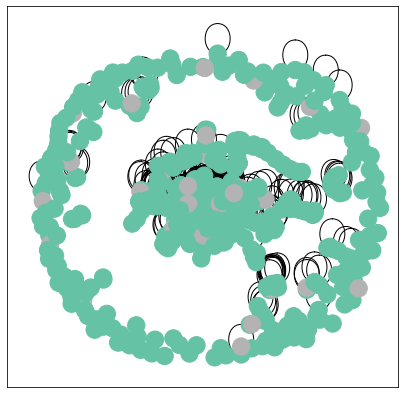

In [ ]:
data, train_data = process()

In [ ]:
### Graph Neural Network Task

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, inputfeatures = 2, hidden_channels = 2, num_classes = 2):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(inputfeatures, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def iterate():
  for epoch in range(1, 101):
      loss = train()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
model = GCN(inputfeatures = 2, hidden_channels = 2, num_classes = 2)
model.double()
print(model)

In [ ]:
model.eval()

In [ ]:
data.x.shape, data.edge_index.shape, data.y.shape, data.edge_attr.shape
# data.edge_index

In [ ]:
# out = model(data.x, data.edge_index)
# visualize(out, color=data.y)

In [ ]:
# iterate()


In [ ]:
# # TODO: Update the function with the library
# def get_label_sequences(fastafile):
#   start = 'NODE_'
#   end = '_length_'
#   features = {}
  
#   with open(fastafile, 'r') as file:
#     line = file.readline()
#     while line != "":
#       attributes = {}
#       if line.startswith(">"):

#         name = line.lstrip(">")
#         contig_num = str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1)
#         predicted_values = predict("")

#         attributes["features"] = predicted_values
#         attributes["class"] = 0.5
#         attributes["train_sem"] = False

#         # TODO Change this
#         color_value = sum(predicted_values) / len(predicted_values)

#         if color_value < 0.4:
#           attributes["class"] = 0
#           attributes["train_sem"] = True
#         elif color_value > 0.8:
#           attributes["class"] = 1
#           attributes["train_sem"] = True

#         features[contig_num] = attributes
#         line = file.readline()

#     return features

mkdir: cannot create directory ‘content/Figures’: No such file or directory
/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Test_Datasets/2c5p 



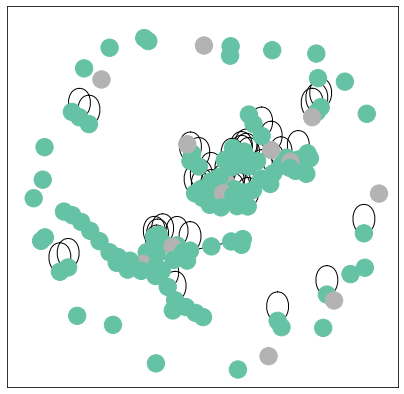

GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)
GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)
Embedding shape: [128, 2]


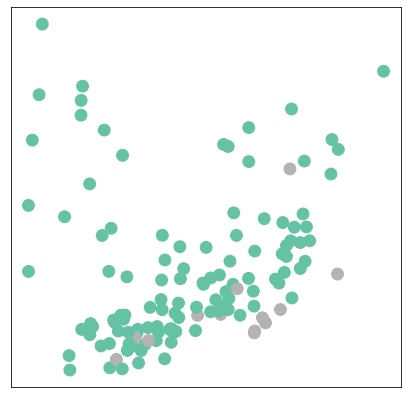

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


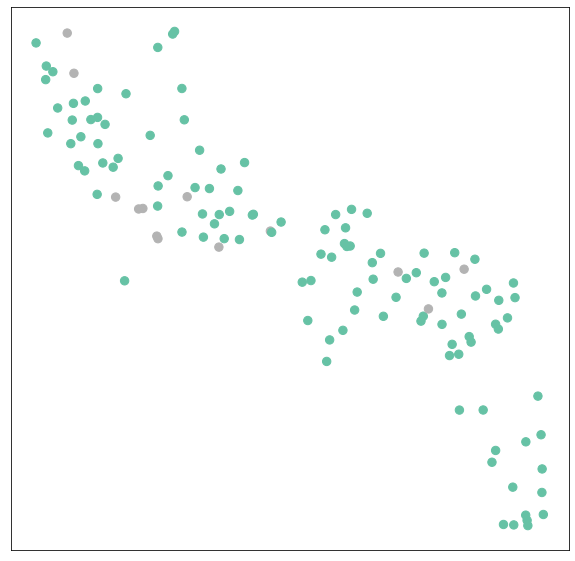

Test Accuracy:  (0.7142857142857143, tensor([[-0.2629,  1.0907],
        [-0.2938,  1.1435],
        [-0.1926,  0.9616],
        [-1.0992,  1.9404],
        [ 0.3010,  0.2747],
        [-0.4815,  1.1218],
        [ 0.1677,  0.3043],
        [-0.1156,  0.5496],
        [-1.2532,  2.5471],
        [-1.2987,  2.2312],
        [ 0.4790, -0.0199],
        [-0.4081,  1.2033],
        [ 0.3737,  0.2690],
        [-0.1038,  0.5687],
        [-0.5647,  1.2238],
        [-0.7877,  1.9647],
        [-0.8905,  1.7875],
        [ 0.1270,  0.4445],
        [ 0.0913,  0.5769],
        [ 0.6165, -0.0983],
        [-0.1595,  0.7171],
        [-0.5668,  1.4540],
        [ 0.4828, -0.0243],
        [-0.6979,  1.6955],
        [ 0.0137,  0.8697],
        [-0.1244,  0.9033],
        [-1.2522,  2.2244],
        [ 0.0298,  0.4856],
        [-0.8021,  1.4858],
        [-0.4754,  1.0005],
        [-0.1518,  0.5274],
        [-0.2650,  1.1372],
        [ 0.1442,  0.4115],
        [-0.3132,  0.8543],
        [-0

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


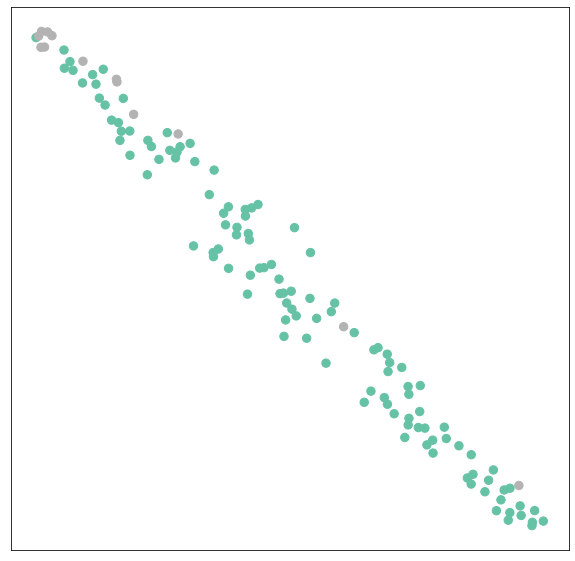

In [ ]:
# -*- coding: utf-8 -*-
"""Dataset-Preparation.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/12VZ0DXvkD7smWXkWQYl89AYhN0XIj95H
"""

# !pip install python-igraph
# !pip install cairocffi



# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install pysam

# pip3 install torch==1.9.0 torchvision==0.10.0
# conda install -c bioconda pysam

# pip3 uninstall torch torch-scatter torch-sparse torch-geometric

# pip3 install torch --no-cache-dir
# pip3 install torch-scatter --no-cache-dir -f https://data.pyg.org/whl/torch-1.10.0+cu102.html
# pip3 install torch-sparse --no-cache-dir -f https://data.pyg.org/whl/torch-1.10.0+cu102.html
# pip3 install torch-geometric --no-cache-dir

# from google.colab import drive
# drive.mount('/content/gdrive')

# gnndatasetpath = "/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Test_Datasets"
# gnndatasetpath = "/home/hp/FYP/GNN/gnn-datasets/Test_Datasets"
gnndatasetpath = "/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Test_Datasets"

_DEBUG = True

# Commented out IPython magic to ensure Python compatibility.
import re
# from igraph import *
from collections import defaultdict
import os
import random

# %matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv

from torch.nn import Linear
import torch.nn.functional as F

from pysam import FastaFile

from sklearn.manifold import TSNE

!mkdir "content/Figures"

## Functions


def visualize(h, color, filename = "test_visualize_graph.png"):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    # plt.savefig(filename)

def visualize_graph(G, color, filename = "test_visualize_graph.png"):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
    # plt.savefig(filename)


def visualize_embedding(h, color, epoch=None, loss=None, filename = "test_visualize_embedding.png"):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
    # plt.savefig(filename)

# TODO: Update the function with the library
def predict(sequence):
  return [random.uniform(0, 1), random.uniform(0, 1)]

# TODO: Update the function with the library
def get_label_sequences(fastafile):
  start = 'NODE_'
  end = '_length_'
  features = {}
  
  fasta_object = FastaFile(fastafile)
  fasta_references = fasta_object.references

  for name in fasta_references:
    attributes = {}

    contig_num = int(str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1))
    predicted_values = predict(fasta_object.fetch(reference = name))

    attributes["features"] = predicted_values
    attributes["class"] = 0.5
    attributes["train_sem"] = False

    # TODO Change this
    color_value = sum(predicted_values) / len(predicted_values)

    if color_value < 0.4:
      attributes["class"] = 0
      attributes["train_sem"] = True
    elif color_value > 0.8:
      attributes["class"] = 1
      attributes["train_sem"] = True

    features[contig_num] = attributes
  return features

def get_the_segment_contig_map(contigfilepath):
  paths = {}
  segment_contigs = {}
  node_count = 0

  with open(contigfilepath) as file:
    name = file.readline()
    path = file.readline()
    
    while name != "" and path != "":
            
        while ";" in path:
            path = path[:-2]+","+file.readline()
        
        start = 'NODE_'
        end = '_length_'
        contig_num = int(str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1))
        
        segments = path.rstrip().split(",")
        
        if contig_num not in paths:
            node_count += 1
            paths[contig_num] = [segments[0], segments[-1]]
        
        for segment in segments:
            # TODO Check this
            if segment.endswith("+") or segment.endswith("-"):
                segment = segment[:-1]
            if segment not in segment_contigs:
                segment_contigs[segment] = set([contig_num])
            else:
                segment_contigs[segment].add(contig_num)
        
        name = file.readline()
        path = file.readline()

    return segment_contigs, paths, node_count

def adjust_weights(weight_list):
  summation = 0
  count = 0
  none_indexes = []
  for i in range(len(weight_list)):
    if weight_list[i] == None:
      none_indexes.append(i)
      continue
    count += 1
    summation += weight_list[i][0]
  
  average_weight = summation / count
  for i in none_indexes:
    weight_list[i] = [average_weight]

  return weight_list

#make segment_contigs global
def generate_edge_tensor(gfafilepath, segment_contigs):
  source_list = []
  destination_list= []
  weight_list = []
  isNeedToAdjustWeights = False

  with open(gfafilepath) as file:
    line = file.readline()
    while line != "":
      # Identify lines with link information
      if "L" in line:
          strings = line.split("\t")
          seg1, seg2 = strings[1], strings[3]
          weight = strings[5].strip()
          contig1 = segment_contigs[seg1]
          contig2 = segment_contigs[seg2]
          for cont1 in contig1:
            for cont2 in contig2:
              source_list.append(cont1)
              destination_list.append(cont2)
              if weight.isnumeric():
                weight_list.append([int(weight)])
              elif weight[:-1].isnumeric():
                weight_list.append([int(weight[:-1])])
              else:
                weight_list.append(None)
                isNeedToAdjustWeights = True
      line = file.readline()
    if isNeedToAdjustWeights:
      weight_list = adjust_weights(weight_list)
    return source_list, destination_list, weight_list


def generate_tensors(features, source_list, destination_list, weight_list, node_count):
  feature_list = []
  catergory_list = []
  train_data = []
  test_data = []
  for i in range(node_count):
    node_features_dict = features[i]
    catergory_list.append(node_features_dict["class"])
    train_data.append(node_features_dict["train_sem"])
    test_data.append(not (node_features_dict["train_sem"]))
    feature_list.append(node_features_dict["features"])
  
  train_tensor = torch.BoolTensor(train_data)
  test_tensor = torch.BoolTensor(test_data)
  
  # node_features = torch.DoubleTensor(feature_list).unsqueeze(1)
  node_features = torch.DoubleTensor(feature_list)
  y = torch.LongTensor(catergory_list)
  # print(source_list)
  # print(destination_list)
  # print(feature_list)
  edge_index = torch.tensor([source_list, destination_list], dtype=torch.long)
  edge_attr = torch.DoubleTensor(weight_list)

  # data = Data(x = node_features, edge_index = edge_index, y = y, edge_attr = edge_attr)
  data = Data(x = node_features, edge_index = edge_index, y = y)
  return data, train_tensor, test_tensor



def generate_data(gfafilepath, contigfilepath, fastafilepath):
  features = get_label_sequences(fastafilepath)
  segment_contigs, paths, node_count = get_the_segment_contig_map(contigfilepath)
  source_list, destination_list, weight_list = generate_edge_tensor(gfafilepath, segment_contigs)
  data, train_data, test_data = generate_tensors(features, source_list, destination_list, weight_list, node_count)
  return data, train_data, test_data

### Graph Neural Network Task

class GCN(torch.nn.Module):
    def __init__(self, inputfeatures = 2, hidden_channels = 2, num_classes = 2):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(inputfeatures, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.classifier = Linear(num_classes, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        # Apply a final (linear) classifier.
        out = self.classifier(x)
        return out, x

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_data], data.y[train_data])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, h

def test():
      model.eval()
      out, h = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      # test_correct = pred[test_data] == data.y[test_data]  # Check against ground-truth labels.
      test_correct = pred[train_data] == data.y[train_data]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_data.sum())  # Derive ratio of correct predictions.
      return test_acc, h

def iterate():
  for epoch in range(1, 101):
      loss = train()
      # print(f'Epoch: ', epoch, "Loss: ", loss)

def process():
  directory = gnndatasetpath
  data = None
  for datafolder in os.listdir(directory):
      dataset = os.path.join(directory, datafolder)
      print(dataset, "\n")
      gfafilepath = str(dataset) + "/assembly_graph_with_scaffolds.gfa"
      contigfilepath = str(dataset) + "/contigs.paths"
      fastafilepath = str(dataset) + "/contigs.fasta"

      data, train_data, test_data = generate_data(gfafilepath, contigfilepath, fastafilepath)

      G = to_networkx(data, to_undirected=True)
      visualize_graph(G, color=data.y, filename = "Figures/test_visualize_graph.png")

      if _DEBUG:
        return data, train_data, test_data
        break

data, train_data, test_data = process()

# from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(inputfeatures = 2, hidden_channels = 16, num_classes = 2)
model.double()
print(model)

eval_results = model.eval()
print(eval_results)

# print("x:- ", len(data.x))
# data.edge_index

out, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y, filename = "Figures/test_visualize_embedding.png")
visualize(h, color=data.y, filename = "Figures/test_visualize.png")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

iterate()

test_acc = test()
print("Test Accuracy: ", test_acc)

model.eval()

out, h = model(data.x, data.edge_index)
visualize(h, color=data.y, filename = "Figures/test_results_visualize_embedding.png")

# # TODO: Update the function with the library
# def get_label_sequences(fastafile):
#   start = 'NODE_'
#   end = '_length_'
#   features = {}
  
#   with open(fastafile, 'r') as file:
#     line = file.readline()
#     while line != "":
#       attributes = {}
#       if line.startswith(">"):

#         name = line.lstrip(">")
#         contig_num = str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1)
#         predicted_values = predict("")

#         attributes["features"] = predicted_values
#         attributes["class"] = 0.5
#         attributes["train_sem"] = False

#         # TODO Change this
#         color_value = sum(predicted_values) / len(predicted_values)

#         if color_value < 0.4:
#           attributes["class"] = 0
#           attributes["train_sem"] = True
#         elif color_value > 0.8:
#           attributes["class"] = 1
#           attributes["train_sem"] = True

#         features[contig_num] = attributes
#         line = file.readline()

#     return features

In [1]:
# !pip install python-igraph
# !pip install cairocffi

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     |████████████████████████████████| 7.9 MB 4.6 MB/s 
     |████████████████████████████████| 3.5 MB 2.9 MB/s 
     |████████████████████████████████| 145 kB 4.9 MB/s 
     |████████████████████████████████| 74 kB 1.8 MB/s 
     |████████████████████████████████| 112 kB 9.9 MB/s 
     |████████████████████████████████| 596 kB 40.0 MB/s 


In [2]:
!pip install pysam

     |████████████████████████████████| 14.9 MB 5.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import os

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
csv_column_names = ["seq_id", "fragment_count","kmer_plas_prob","biomer_plas_prob", "final_plas_prob", "class"]
upper_bound = 0.8
lower_bound = 0.3
fragment_limit = 10

# root = "/home/hp/FYP/GNN/gnn-code/rawdata/raw"

def preprocess(filename):
    df = pd.read_csv(filename)
    df = df[csv_column_names]
    # df.to_csv(filename)
    df["class"] = df["class"] == "plasmid"
    df["class"] = df["class"].astype(int)
    df["train_set"] = df.apply(lambda row: (not((lower_bound < row["final_plas_prob"] < upper_bound) or row["fragment_count"] < fragment_limit)), axis = 1)
    df["find_set"] = df.apply(lambda row: ((lower_bound < row["final_plas_prob"] < upper_bound) or row["fragment_count"] < fragment_limit), axis = 1)
    return df

In [5]:
import re

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.utils.data import DataLoader

from pysam import FastaFile

_DEBUG = False

def get_the_segment_contig_map(contigfilepath):
  paths = {}
  segment_contigs = {}
  node_count = 0

  with open(contigfilepath) as file:
    name = file.readline()
    path = file.readline()
    
    while name != "" and path != "":
            
        while ";" in path:
            path = path[:-2]+","+file.readline()
        
        start = 'NODE_'
        end = '_length_'
        contig_num = int(str(int(re.search('%s(.*)%s' % (start, end), name).group(1))-1))
        
        segments = path.rstrip().split(",")
        
        if contig_num not in paths:
            node_count += 1
            paths[contig_num] = [segments[0], segments[-1]]
        
        for segment in segments:
            # TODO Check this
            if segment.endswith("+") or segment.endswith("-"):
                segment = segment[:-1]
            if segment not in segment_contigs:
                segment_contigs[segment] = set([contig_num])
            else:
                segment_contigs[segment].add(contig_num)
        
        name = file.readline()
        path = file.readline()

    return segment_contigs, paths, node_count

def adjust_weights(weight_list):
  summation = 0
  count = 0
  none_indexes = []
  for i in range(len(weight_list)):
    if weight_list[i] == None:
      none_indexes.append(i)
      continue
    count += 1
    summation += weight_list[i][0]
  
  average_weight = summation / count
  for i in none_indexes:
    weight_list[i] = [average_weight]

  return weight_list

#make segment_contigs global
def generate_edge_tensor(gfafilepath, segment_contigs):
  source_list = []
  destination_list= []
  weight_list = []
  isNeedToAdjustWeights = False

  with open(gfafilepath) as file:
    line = file.readline()
    if _DEBUG:
      line_count = 1
    while line != "":
      # Identify lines with link information
      if "L" in line:
          strings = line.split("\t")
          seg1, seg2 = strings[1], strings[3]
          weight = strings[5].strip()
          if seg1 not in segment_contigs or seg2 not in segment_contigs:
            line = file.readline()
            if _DEBUG:
              line_count += 1
            continue
          contig1 = segment_contigs[seg1]
          contig2 = segment_contigs[seg2]
          if _DEBUG:
            print(line_count, contig1, contig2)
          for cont1 in contig1:
            for cont2 in contig2:
              if cont1 != cont2:
                source_list.append(cont1)
                destination_list.append(cont2)
                if weight.isnumeric():
                  weight_list.append([int(weight)])
                elif weight[:-1].isnumeric():
                  weight_list.append([int(weight[:-1])])
                else:
                  weight_list.append(None)
                  isNeedToAdjustWeights = True
      line = file.readline()
      if _DEBUG:
        line_count += 1
        # print(line_count)
    if _DEBUG:
      print("Finished the reading part of GFA File")
    if isNeedToAdjustWeights:
      weight_list = adjust_weights(weight_list)
    return source_list, destination_list, weight_list

In [6]:

import shutil

!mkdir "/content/data"
# !mkdir "/content/data/raw"

gnndatasetpath = "/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Test_Datasets"
csvfolder = "/content/gdrive/Shareddrives/FYP/DataSets/Gnn-Dataset/Results"
try:
  shutil.copytree(csvfolder, "/content/data/raw")
except:
  pass

mkdir: cannot create directory ‘/content/data’: File exists


In [7]:

processed_dir = "/content/processed"

row_files = os.listdir(csvfolder)

In [8]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm
import os

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

class UserDataset(Dataset):
    def __init__(self, root, raw_file, path, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        # self.filename = filename
        self.raw_file = raw_file
        self.path = path
        self.src = root
        # self.processed_dir = processed_dir
        self.train_set = None
        self.cv_set = None
        self.test_set = None
        self.find_set = None
        super(UserDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.raw_file

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def get_name(self, file):
        name =  os.path.splitext(file)[0]
        if "/" not in name:
          return name
        else:
          return (name.split("/"))[-1]

    def process(self):
        gfafilepath = self.path + "/assembly_graph_with_scaffolds.gfa"
        contigfilepath = self.path + "/contigs.paths"
        fastafilepath = self.path + "/contigs.fasta"

        segment_contigs, paths, node_count = get_the_segment_contig_map(contigfilepath)
        source_list, destination_list, weight_list = generate_edge_tensor(gfafilepath, segment_contigs)
        feature_df = preprocess(self.raw_paths[0])

        node_features = torch.DoubleTensor(feature_df[["fragment_count","kmer_plas_prob","biomer_plas_prob", "final_plas_prob"]].values)
        edge_index = torch.tensor([source_list, destination_list], dtype=torch.long)
        edge_attr = torch.DoubleTensor(weight_list)
        y = feature_df["class"]

        self.train_set = feature_df["train_set"].values
        self.find_set = feature_df["find_set"].values

        # Create data object
        data = Data(
            x=node_features, 
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y) 
        
        if self.test:
            torch.save(data, 
                os.path.join(self.processed_dir, 
                              f'data_test_{(self.get_name(self.raw_paths[0]))}.pt'))
        else:
            torch.save(data, 
                os.path.join(self.processed_dir, 
                              f'data_{(self.get_name(self.raw_paths[0]))}.pt'))
            
        # data, slices = self.collate([self.data])
        # torch.save((data, slices), self.processed_dir)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                              f'data_test_{(self.get_name(self.raw_paths[0]))}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                              f'data_{(self.get_name(self.raw_paths[0]))}.pt'))   
        return data

class DeviceDict:
    def __init__(self, data):
        self.data = data 

    def print_data(self):
        print(self.data)

def custom_collate(dict):
    return DeviceDict(dict)



# ..............................................................................

paths = os.listdir(gnndatasetpath)
for i in range(len(paths)):
  paths[i] = gnndatasetpath + "/" + paths[i]

userdataset = UserDataset(root = "/content/data/", raw_file = row_files[0], path = paths[0])

# print("\nlen(userdataset.data) " , len(userdataset.data))
# userdataset.data




Torch version: 1.10.0+cu111
Cuda available: False
Torch geometric version: 2.0.4


Processing...
Done!


In [9]:
userdataset.get("wastewater_predictions.pt")

Data(x=[32510, 4], edge_index=[2, 449], edge_attr=[449, 1], y=0        1
1        1
2        1
3        1
4        1
        ..
32505    1
32506    1
32507    1
32508    1
32509    1
Name: class, Length: 32510, dtype: int64)

In [10]:
print(userdataset.data.shape[0])
userdataset.data

32510


,index,seq_id,fragment_count,kmer_chro_prob,kmer_plas_prob,kmer_prediction_avg,biomer_chro_prob,biomer_plas_prob,biomer_prediction,sum,product,final_plas_prob,class
0,0,NODE_1_length_111763_cov_62.554777,100,0.186584,8.134166e-01,0.950000,0.00,1.00,1,0.906708,0.901896,0.999958,plasmid
1,1,NODE_2_length_107210_cov_17.622211,100,0.203819,7.961805e-01,0.890000,0.00,1.00,1,0.898090,0.892289,0.999953,plasmid
2,2,NODE_3_length_99024_cov_41.494387,100,0.367815,6.321852e-01,0.690000,0.00,1.00,1,0.816093,0.795101,0.999876,plasmid
3,3,NODE_4_length_85557_cov_5.894751,86,0.707138,2.928625e-01,0.162791,0.00,1.00,1,0.646431,0.541168,0.999083,plasmid
4,4,NODE_5_length_80510_cov_42.990852,81,0.292630,7.073693e-01,0.839506,0.00,1.00,1,0.853685,0.841053,0.999921,plasmid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32505,32505,NODE_32506_length_56_cov_7.000000,1,1.000000,1.203526e-10,0.000000,0.00,1.00,1,0.500000,0.000011,0.994842,plasmid
32506,32506,NODE_32507_length_56_cov_6.000000,1,0.517626,4.823743e-01,0.000000,0.00,1.00,1,0.741187,0.694532,0.999701,plasmid
32507,32507,NODE_32508_length_56_cov_5.000000,1,1.000000,1.464753e-09,0.000000,0.04,0.96,1,0.480000,0.000037,0.992091,plasmid
32508,32508,NODE_32509_length_56_cov_3.000000,1,1.000000,3.052292e-10,0.000000,0.04,0.96,1,0.480000,0.000017,0.992091,plasmid


In [ ]:
loader = DataLoader(userdataset, batch_size=1000, shuffle=True,collate_fn=custom_collate)
t = next(iter(loader))
# t.print_data()

for batch in iter(loader):
    print(batch.data)
# loader

Streaming output truncated to the last 5000 lines.
32505    1
32506    1
32507    1
32508    1
32509    1
Name: class, Length: 32510, dtype: int64), Data(x=[32510, 4], edge_index=[2, 449], edge_attr=[449, 1], y=0        1
1        1
2        1
3        1
4        1
        ..
32505    1
32506    1
32507    1
32508    1
32509    1
Name: class, Length: 32510, dtype: int64), Data(x=[32510, 4], edge_index=[2, 449], edge_attr=[449, 1], y=0        1
1        1
2        1
3        1
4        1
        ..
32505    1
32506    1
32507    1
32508    1
32509    1
Name: class, Length: 32510, dtype: int64), Data(x=[32510, 4], edge_index=[2, 449], edge_attr=[449, 1], y=0        1
1        1
2        1
3        1
4        1
        ..
32505    1
32506    1
32507    1
32508    1
32509    1
Name: class, Length: 32510, dtype: int64), Data(x=[32510, 4], edge_index=[2, 449], edge_attr=[449, 1], y=0        1
1        1
2        1
3        1
4        1
        ..
32505    1
32506    1
32507    1
32508    1
3